## Libararies

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)

## Load Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("wordsforthewise/lending-club")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Lenovo\.cache\kagglehub\datasets\wordsforthewise\lending-club\versions\3


In [4]:
# Use correct file path and filename
filepath = os.path.join(path, "accepted_2007_to_2018Q4.csv.gz")

df = pd.read_csv(filepath, low_memory=False)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Filter out relevent columns for our research question

In [5]:
relevant_columns = [
    # Loan Characteristics
    "loan_amnt",
    "term",
    "int_rate",
    "grade",
    "purpose",
    # Borrower's Financials & History
    "annual_inc",
    "dti",
    "delinq_2yrs",
    "inq_last_6mths",
    "home_ownership",
    "emp_length",
    "fico_range_low",
    "fico_range_high",
    "issue_d",
    "earliest_cr_line",
    "open_acc",
    "pub_rec",
    "revol_bal",
    "revol_util",
    "total_acc",
    "verification_status",
    "application_type",
    "addr_state",
    # Target Variable
    "loan_status",
]
df = df[relevant_columns]
df.head()

,loan_amnt,term,int_rate,grade,purpose,annual_inc,dti,delinq_2yrs,inq_last_6mths,home_ownership,...,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,verification_status,application_type,addr_state,loan_status
0,3600.0,36 months,13.99,C,debt_consolidation,55000.0,5.91,0.0,1.0,MORTGAGE,...,Aug-2003,7.0,0.0,2765.0,29.7,13.0,Not Verified,Individual,PA,Fully Paid
1,24700.0,36 months,11.99,C,small_business,65000.0,16.06,1.0,4.0,MORTGAGE,...,Dec-1999,22.0,0.0,21470.0,19.2,38.0,Not Verified,Individual,SD,Fully Paid
2,20000.0,60 months,10.78,B,home_improvement,63000.0,10.78,0.0,0.0,MORTGAGE,...,Aug-2000,6.0,0.0,7869.0,56.2,18.0,Not Verified,Joint App,IL,Fully Paid
3,35000.0,60 months,14.85,C,debt_consolidation,110000.0,17.06,0.0,0.0,MORTGAGE,...,Sep-2008,13.0,0.0,7802.0,11.6,17.0,Source Verified,Individual,NJ,Current
4,10400.0,60 months,22.45,F,major_purchase,104433.0,25.37,1.0,3.0,MORTGAGE,...,Jun-1998,12.0,0.0,21929.0,64.5,35.0,Source Verified,Individual,PA,Fully Paid


## Target Variables

In [6]:
df["loan_status"].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

**Target feature change into Binary**

In [7]:
# Create a binary target variable: 1 for default, 0 for non-default
bad_statuses = ["Charged Off", "Default"]
df["is_default"] = df["loan_status"].apply(lambda x: 1 if x in bad_statuses else 0)

# Filter for only loans with a resolved outcome
resolved_statuses = ["Fully Paid"] + bad_statuses
df_cleaned = df[df["loan_status"].isin(resolved_statuses)].copy()
df_cleaned = df_cleaned.drop("loan_status", axis=1)

print(f"Original shape: {df.shape}")
print(f"Shape after filtering for resolved loans: {df_cleaned.shape}")
df["is_default"].value_counts()

Original shape: (2260701, 25)
Shape after filtering for resolved loans: (1345350, 24)


is_default
0    1992102
1     268599
Name: count, dtype: int64

## Missing Values

In [8]:
# Function to fill missing values
def fill_missing_values(df):
    """
    Fills missing values in a DataFrame based on column data type.

    Args:
      df: The input pandas DataFrame.

    Returns:
      The DataFrame with missing values filled.
    """
    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype in ["int64", "float64"]:
                mean_val = df[col].mean()
                df[col].fillna(mean_val, inplace=True)
            else:
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
    return df


df = fill_missing_values(df_cleaned)

print("Missing values after filling:")
print(df.isna().sum())

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26280\1951051308.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mean_val, inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26280\1951051308.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

Missing values after filling:
loan_amnt              0
term                   0
int_rate               0
grade                  0
purpose                0
annual_inc             0
dti                    0
delinq_2yrs            0
inq_last_6mths         0
home_ownership         0
emp_length             0
fico_range_low         0
fico_range_high        0
issue_d                0
earliest_cr_line       0
open_acc               0
pub_rec                0
revol_bal              0
revol_util             0
total_acc              0
verification_status    0
application_type       0
addr_state             0
is_default             0
dtype: int64


## Date time/Category Values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1345350 entries, 0 to 2260697
Data columns (total 24 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   loan_amnt            1345350 non-null  float64
 1   term                 1345350 non-null  object 
 2   int_rate             1345350 non-null  float64
 3   grade                1345350 non-null  object 
 4   purpose              1345350 non-null  object 
 5   annual_inc           1345350 non-null  float64
 6   dti                  1345350 non-null  float64
 7   delinq_2yrs          1345350 non-null  float64
 8   inq_last_6mths       1345350 non-null  float64
 9   home_ownership       1345350 non-null  object 
 10  emp_length           1345350 non-null  object 
 11  fico_range_low       1345350 non-null  float64
 12  fico_range_high      1345350 non-null  float64
 13  issue_d              1345350 non-null  object 
 14  earliest_cr_line     1345350 non-null  object 
 15  ope

In [10]:
df.select_dtypes(include=["object"]).head()

,term,grade,purpose,home_ownership,emp_length,issue_d,earliest_cr_line,verification_status,application_type,addr_state
0,36 months,C,debt_consolidation,MORTGAGE,10+ years,Dec-2015,Aug-2003,Not Verified,Individual,PA
1,36 months,C,small_business,MORTGAGE,10+ years,Dec-2015,Dec-1999,Not Verified,Individual,SD
2,60 months,B,home_improvement,MORTGAGE,10+ years,Dec-2015,Aug-2000,Not Verified,Joint App,IL
4,60 months,F,major_purchase,MORTGAGE,3 years,Dec-2015,Jun-1998,Source Verified,Individual,PA
5,36 months,C,debt_consolidation,RENT,4 years,Dec-2015,Oct-1987,Source Verified,Individual,GA


**Convert dates to date-time type**

In [11]:
# Engineer credit history length
# Check if the original date columns exist
if "issue_d" in df.columns and "earliest_cr_line" in df.columns:
    print("Engineering 'credit_history_length'...")
    # Ensure columns are datetime before performing operations
    df["issue_d"] = pd.to_datetime(df["issue_d"])
    df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"])
    df["credit_history_length"] = (
        (df["issue_d"] - df["earliest_cr_line"]).dt.days / 30
    ).round(0)
    # Drop original date columns now that we're done with them
    df = df.drop(columns=["issue_d", "earliest_cr_line"], errors="ignore")

df["credit_history_length"].head()

Engineering 'credit_history_length'...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26280\4159934486.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["issue_d"] = pd.to_datetime(df["issue_d"])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26280\4159934486.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"])


0    150.0
1    195.0
2    187.0
4    213.0
5    343.0
Name: credit_history_length, dtype: float64

**Strip leading/tailing white spaces**

In [12]:
df = df.apply(lambda col: col.str.strip() if col.dtypes == "object" else col)

In [13]:
# Clean 'term' column (e.g., ' 36 months' -> 36)
df["term"] = df["term"].str.extract("(\d+)").astype(int)
# Clean and map 'emp_length' to numerical values
emp_length_map = {
    "< 1 year": 0.5,
    "1 year": 1,
    "2 years": 2,
    "3 years": 3,
    "4 years": 4,
    "5 years": 5,
    "6 years": 6,
    "7 years": 7,
    "8 years": 8,
    "9 years": 9,
    "10+ years": 10,
}
df["emp_length"] = df["emp_length"].map(emp_length_map)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_26280\3708040124.py:2: SyntaxWarning: invalid escape sequence '\d'
  df["term"] = df["term"].str.extract("(\d+)").astype(int)


In [14]:
def value_counter(df):
    for col in df.select_dtypes(["object"]).columns:
        print(df[col].value_counts(dropna=False))


value_counter(df)

grade
B    392748
C    381694
A    235095
D    200966
E     93656
F     32059
G      9132
Name: count, dtype: int64
purpose
debt_consolidation    780342
credit_card           295285
home_improvement       87507
other                  77877
major_purchase         29427
medical                15556
small_business         15416
car                    14588
moving                  9480
vacation                9065
house                   7254
wedding                 2294
renewable_energy         933
educational              326
Name: count, dtype: int64
home_ownership
MORTGAGE    665596
RENT        534436
OWN         144840
ANY            286
OTHER          144
NONE            48
Name: count, dtype: int64
verification_status
Source Verified    521289
Verified           418352
Not Verified       405709
Name: count, dtype: int64
application_type
Individual    1319544
Joint App       25806
Name: count, dtype: int64
addr_state
CA    196529
TX    110173
NY    109849
FL     95611
IL     51723
NJ

In [15]:
# In home_ownership column, 'ANY,OTHER and NONE' do not make sense to be alone
# themselves so that will group into 'OTHER'
home_ownership_mapping = {
    "ANY": "other",
    "MORTGAGE": "mortgage",
    "RENT": "rent",
    "OWN": "own",
    "NONE": "other",
}
df.home_ownership = df.home_ownership.map(home_ownership_mapping)

In [16]:
# Engineer a single FICO score
# Check if the original FICO columns still exist before trying to create the new one
if "fico_range_low" in df.columns and "fico_range_high" in df.columns:
    print("Engineering 'fico_score'...")
    df["fico_score"] = (df["fico_range_low"] + df["fico_range_high"]) / 2
    df = df.drop(columns=["fico_range_low", "fico_range_high"])

print(df["fico_score"].dtypes)
df["fico_score"].head()

Engineering 'fico_score'...
float64


0    677.0
1    717.0
2    697.0
4    697.0
5    692.0
Name: fico_score, dtype: float64

## All to Numeric Features

In [17]:
cat_cols = df.select_dtypes(include=["object"]).columns
num_cols = df.select_dtypes(exclude=["object"]).drop("is_default", axis=1).columns

# Concatenate numeric columns explicitly
df_final = pd.concat(
    [df[num_cols], pd.get_dummies(df[cat_cols], drop_first=True), df["is_default"]],
    axis=1,
)
df_final.head()

,loan_amnt,term,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,emp_length,open_acc,pub_rec,...,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,is_default
0,3600.0,36,13.99,55000.0,5.91,0.0,1.0,10.0,7.0,0.0,...,False,False,False,False,False,False,False,False,False,0
1,24700.0,36,11.99,65000.0,16.06,1.0,4.0,10.0,22.0,0.0,...,False,False,False,False,False,False,False,False,False,0
2,20000.0,60,10.78,63000.0,10.78,0.0,0.0,10.0,6.0,0.0,...,False,False,False,False,False,False,False,False,False,0
4,10400.0,60,22.45,104433.0,25.37,1.0,3.0,3.0,12.0,0.0,...,False,False,False,False,False,False,False,False,False,0
5,11950.0,36,13.44,34000.0,10.20,0.0,0.0,4.0,5.0,0.0,...,False,False,False,False,False,False,False,False,False,0


In [18]:
# Save the final processed DataFrame to a CSV file
output_csv = "processed_lending_club_data.csv"
df_final.to_csv(output_csv, index=False)
print(f"Processed data saved to {output_csv}")

Processed data saved to processed_lending_club_data.csv


## Preporcessing

In [17]:
# Preprocess Data
X = df_final.drop("is_default", axis=1)
y = df_final["is_default"]

# Scale numeric features
X_scaled = X.copy()
num_cols = X.select_dtypes(include=["float64", "int64"]).columns
scaler = StandardScaler()
X_scaled[num_cols] = scaler.fit_transform(X[num_cols])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Training

In [18]:
# Initialize models
logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

pos_weight = df["is_default"].value_counts()[0] / df["is_default"].value_counts()[1]
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=pos_weight,
    random_state=42,
)

In [19]:
# Logistic Regression
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
y_proba_log = logreg.predict_proba(X_test)[:, 1]  # Probabilities

# Random Forest
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]  # Probabilities

# XGBoost
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]  # Probabilities

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [18:42:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Evaluation

In [20]:
# Evaluation function
def evaluate_model(y_test, y_pred, y_proba, model_name):
    print(f"\n=== {model_name} ===")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))


# Evaluate all models
evaluate_model(y_test, y_pred_log, y_proba_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, y_proba_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.89      0.63      0.74    215385
           1       0.31      0.67      0.43     53685

    accuracy                           0.64    269070
   macro avg       0.60      0.65      0.58    269070
weighted avg       0.77      0.64      0.68    269070

Confusion Matrix:
 [[136725  78660]
 [ 17629  36056]]
ROC-AUC: 0.7111720249248207

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    215385
           1       0.55      0.06      0.10     53685

    accuracy                           0.80    269070
   macro avg       0.68      0.52      0.50    269070
weighted avg       0.76      0.80      0.73    269070

Confusion Matrix:
 [[212906   2479]
 [ 50687   2998]]
ROC-AUC: 0.706737194122252

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.89      0.65      0.75    215385
     

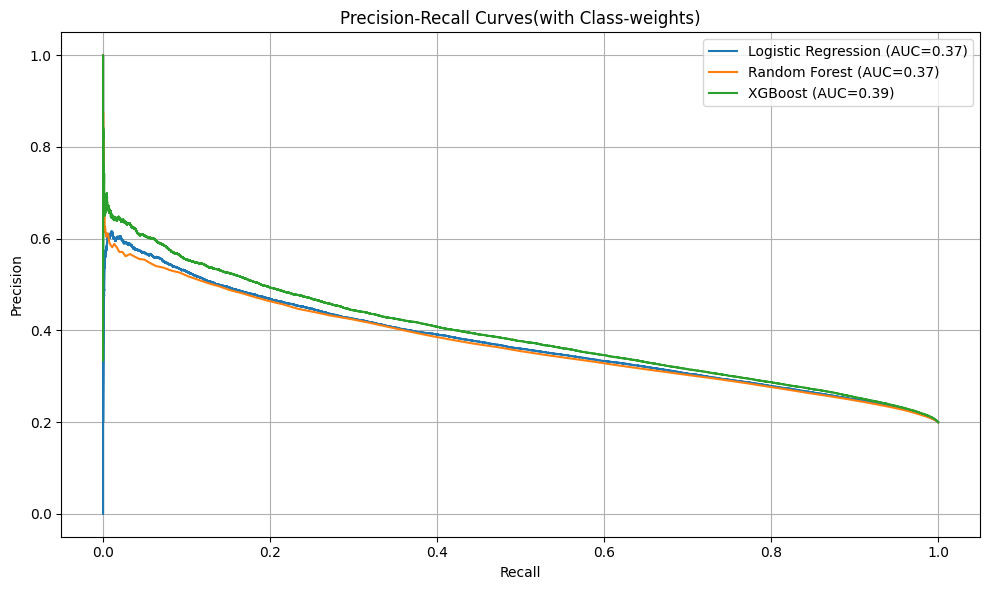

In [21]:
# Plot Precision-Recall Curves
plt.figure(figsize=(10, 6))
for y_proba, name in zip(
    [y_proba_log, y_proba_rf, y_proba_xgb],
    ["Logistic Regression", "Random Forest", "XGBoost"],
):
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC={pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves(with Class-weights)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importance

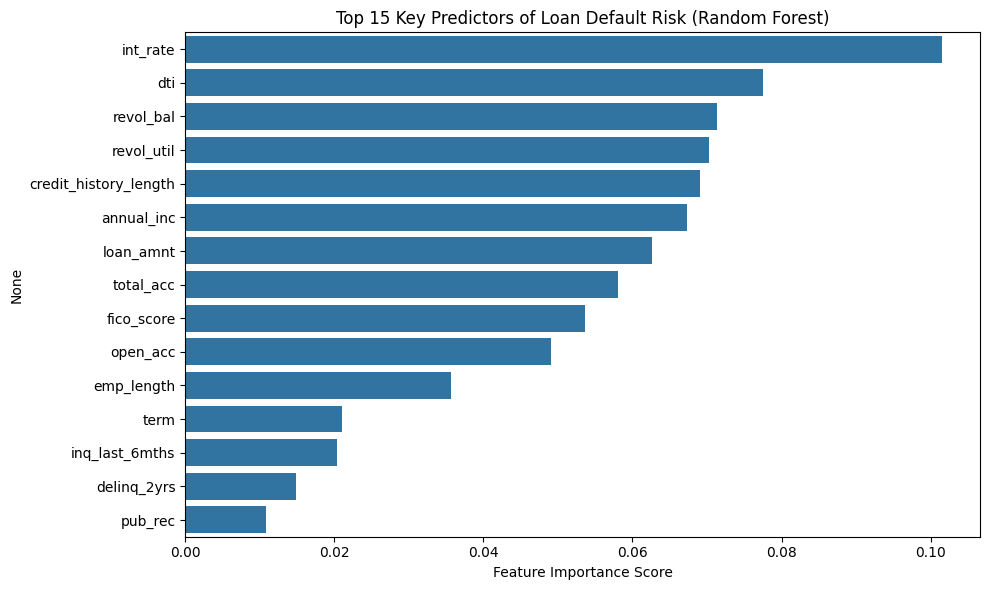

In [22]:
# Random Forest
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(
    ascending=False
)

# Plot Top 15 Features
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_importances[:15], y=rf_importances.index[:15])
plt.title("Top 15 Key Predictors of Loan Default Risk (Random Forest)")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()

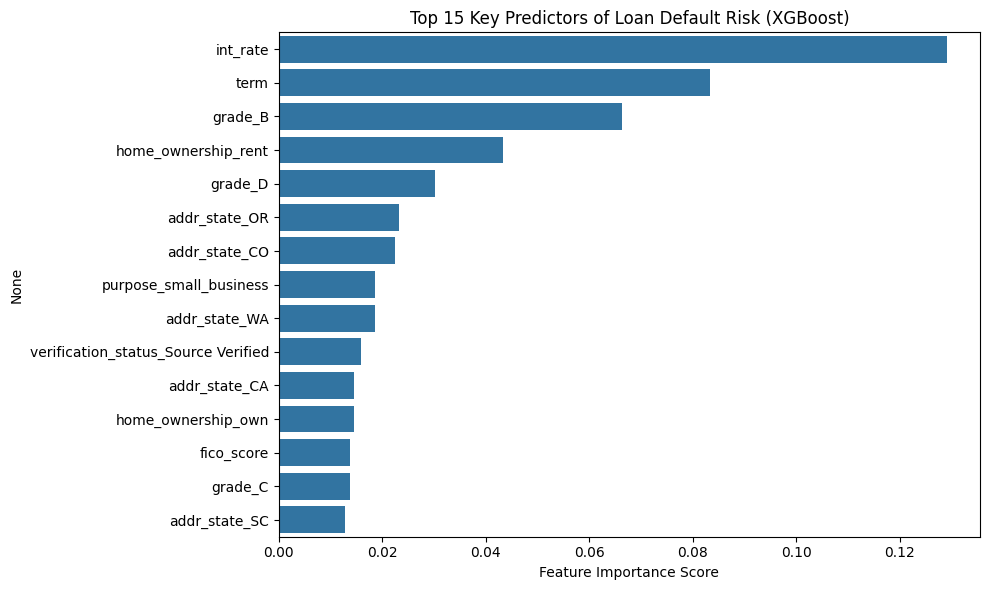

In [23]:
# XGBoost
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(
    ascending=False
)

# Plot Top 15 Features
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importances[:15], y=xgb_importances.index[:15])
plt.title("Top 15 Key Predictors of Loan Default Risk (XGBoost)")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()

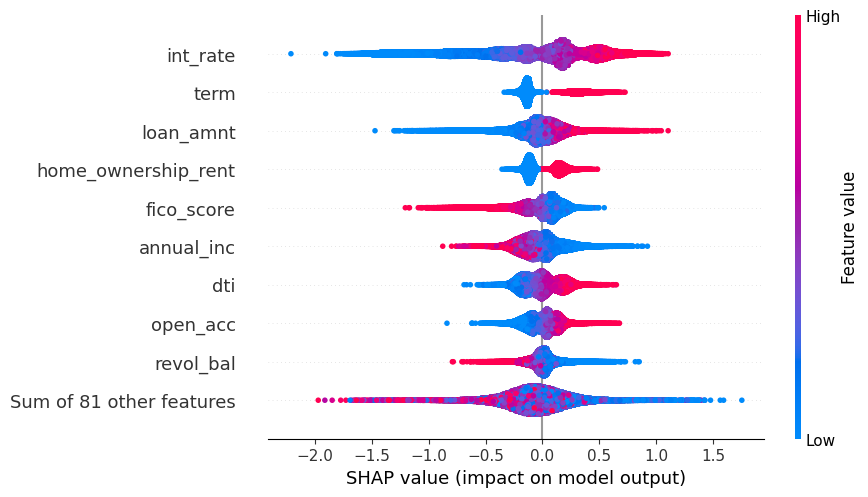

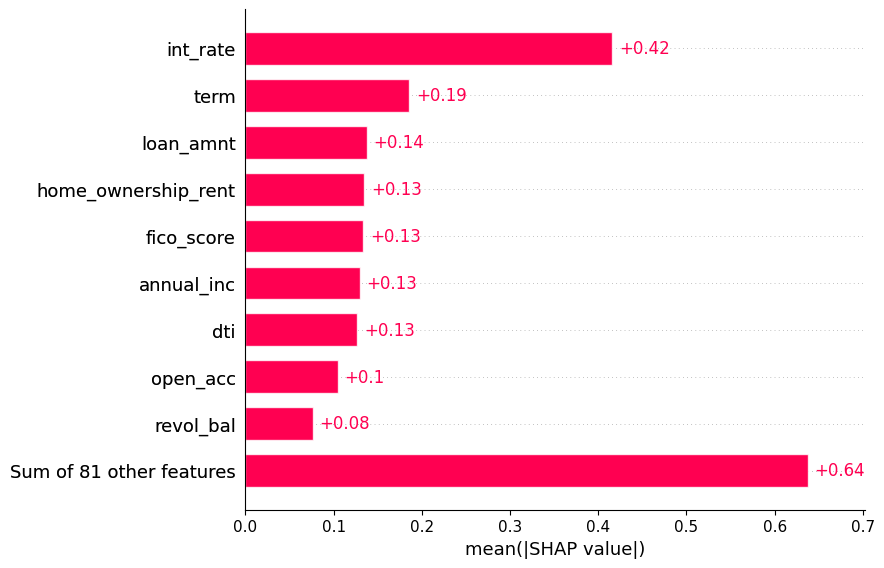

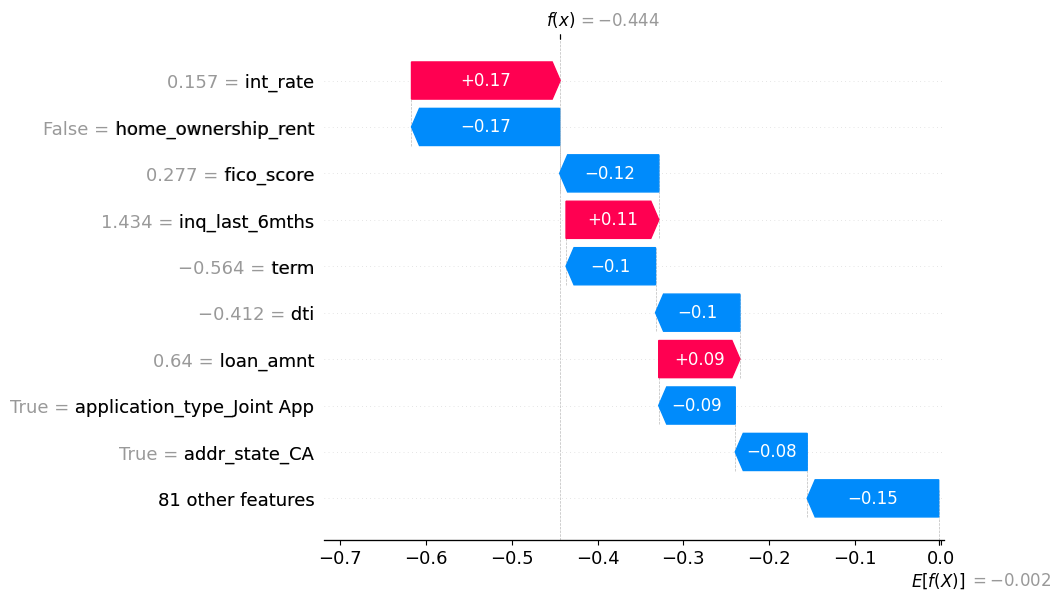

In [24]:
import shap

# Fit SHAP explainer on the XGBoost model
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary plot: shows global feature importance
shap.plots.beeswarm(shap_values)

# Alternatively for older matplotlib-based plot:
# shap.summary_plot(shap_values, X_test)

# Feature importance (bar chart)
shap.plots.bar(shap_values)

# Explain a single prediction (choose any row from X_test)
i = 0  # First instance
shap.plots.waterfall(shap_values[i])

## Save XGB Model

In [27]:
# Save XGBoost model to pickle file
import joblib

joblib.dump(xgb, "xgb_model.pkl")

['xgb_model.pkl']